In [ ]:
import os
# Find the latest version of spark 3.0  from http://www-us.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.1'
spark_version = 'spark-3.0.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:5 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get

In [ ]:

# Download the Postgres driver that will allow Spark to interact with Postgres.
!wget https://jdbc.postgresql.org/download/postgresql-42.2.16.jar

--2021-02-07 09:57:36--  https://jdbc.postgresql.org/download/postgresql-42.2.16.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1002883 (979K) [application/java-archive]
Saving to: ‘postgresql-42.2.16.jar’

postgresql-42.2.16. 100%[===================>] 979.38K  1.69MB/s    in 0.6s    

2021-02-07 09:57:37 (1.69 MB/s) - ‘postgresql-42.2.16.jar’ saved [1002883/1002883]



In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("datafinal").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

##  Spark DataFrames and ETL process

In [ ]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url ="https://reno8946-bucket.s3.us-east-2.amazonaws.com/test.csv"
spark.sparkContext.addFile(url)
test_df = spark.read.csv(SparkFiles.get("test.csv"), sep=",", header=True, inferSchema=True)

In [ ]:
# Show DataFrame
test_df.show()

+---+------+------+-----------------+---+---------------+--------+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+---------------+----------------+-----------+--------------------------+------------------------+--------------------+
|_c0|    id|Gender|    Customer Type|Age| Type of Travel|   Class|Flight Distance|Inflight wifi service|Departure/Arrival time convenient|Ease of Online booking|Gate location|Food and drink|Online boarding|Seat comfort|Inflight entertainment|On-board service|Leg room service|Baggage handling|Checkin service|Inflight service|Cleanliness|Departure Delay in Minutes|Arrival Delay in Minutes|        satisfaction|
+---+------+------+-----------------+---+---------------+--------+---------------+---------------------+---------------------------------+----------------------+-------------+-

In [ ]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url ="https://reno8946-bucket.s3.us-east-2.amazonaws.com/train.csv"
spark.sparkContext.addFile(url)
train_df = spark.read.csv(SparkFiles.get("train.csv"), sep=",", header=True, inferSchema=True)

In [ ]:
# Show DataFrame
train_df.show()

+---+------+------+-----------------+---+---------------+--------+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+---------------+----------------+-----------+--------------------------+------------------------+--------------------+
|_c0|    id|Gender|    Customer Type|Age| Type of Travel|   Class|Flight Distance|Inflight wifi service|Departure/Arrival time convenient|Ease of Online booking|Gate location|Food and drink|Online boarding|Seat comfort|Inflight entertainment|On-board service|Leg room service|Baggage handling|Checkin service|Inflight service|Cleanliness|Departure Delay in Minutes|Arrival Delay in Minutes|        satisfaction|
+---+------+------+-----------------+---+---------------+--------+---------------+---------------------+---------------------------------+----------------------+-------------+-

In [ ]:
# Row count of train.df
train_df.count()

103904

In [ ]:
#Concatenate dataframes
def append_dfs(train_df,test_df):
    list1 = train_df.columns
    list2 = test_df.columns
    for col in list2:
        if(col not in list1):
            train_df = train_df.withColumn(col, F.lit(None))
    for col in list1:
        if(col not in list2):
            test_df = test_df.withColumn(col, F.lit(None))
    return train_df.unionByName(test_df)
final_df = append_dfs(train_df,test_df)
final_df.show()

+---+------+------+-----------------+---+---------------+--------+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+---------------+----------------+-----------+--------------------------+------------------------+--------------------+
|_c0|    id|Gender|    Customer Type|Age| Type of Travel|   Class|Flight Distance|Inflight wifi service|Departure/Arrival time convenient|Ease of Online booking|Gate location|Food and drink|Online boarding|Seat comfort|Inflight entertainment|On-board service|Leg room service|Baggage handling|Checkin service|Inflight service|Cleanliness|Departure Delay in Minutes|Arrival Delay in Minutes|        satisfaction|
+---+------+------+-----------------+---+---------------+--------+---------------+---------------------+---------------------------------+----------------------+-------------+-

In [ ]:
final_df.columns

['_c0',
 'id',
 'Gender',
 'Customer Type',
 'Age',
 'Type of Travel',
 'Class',
 'Flight Distance',
 'Inflight wifi service',
 'Departure/Arrival time convenient',
 'Ease of Online booking',
 'Gate location',
 'Food and drink',
 'Online boarding',
 'Seat comfort',
 'Inflight entertainment',
 'On-board service',
 'Leg room service',
 'Baggage handling',
 'Checkin service',
 'Inflight service',
 'Cleanliness',
 'Departure Delay in Minutes',
 'Arrival Delay in Minutes',
 'satisfaction']

In [ ]:
# row count of concatenated file
final_df.describe()

DataFrame[summary: string, _c0: string, id: string, Gender: string, Customer Type: string, Age: string, Type of Travel: string, Class: string, Flight Distance: string, Inflight wifi service: string, Departure/Arrival time convenient: string, Ease of Online booking: string, Gate location: string, Food and drink: string, Online boarding: string, Seat comfort: string, Inflight entertainment: string, On-board service: string, Leg room service: string, Baggage handling: string, Checkin service: string, Inflight service: string, Cleanliness: string, Departure Delay in Minutes: string, Arrival Delay in Minutes: string, satisfaction: string]

In [ ]:
# Rename columns
final_df=final_df.withColumnRenamed("Food and drink", "Food_and_drink").withColumnRenamed("Type of Travel", "Type_of_Travel").withColumnRenamed("Departure/Arrival time convenient", "Departure/Arrival_time_convenient").withColumnRenamed("Ease of Online booking", "Ease_of_Online_booking").withColumnRenamed("Gate location", "Gate_location").withColumnRenamed("Departure Delay in Minutes", "Departure_Delay_in_Minutes").withColumnRenamed("Arrival Delay in Minutes", "Arrival_Delay_in_Minutes").withColumnRenamed("Customer Type", "Customer").withColumnRenamed("Inflight wifi service", "Inflight wifi").withColumnRenamed("Ease_of_Online_booking", "Ease_of_Online booking")


In [ ]:
# Drop NAs
final_df=final_df.dropna()

In [ ]:
# Drop index and id columns
airline_df=final_df.drop('_c0','id')
airline_df.show()

+------+-----------------+---+---------------+--------+---------------+-------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+---------------+----------------+-----------+--------------------------+------------------------+--------------------+
|Gender|         Customer|Age| Type_of_Travel|   Class|Flight Distance|Inflight wifi|Departure/Arrival_time_convenient|Ease_of_Online booking|Gate_location|Food_and_drink|Online boarding|Seat comfort|Inflight entertainment|On-board service|Leg room service|Baggage handling|Checkin service|Inflight service|Cleanliness|Departure_Delay_in_Minutes|Arrival_Delay_in_Minutes|        satisfaction|
+------+-----------------+---+---------------+--------+---------------+-------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+--------------

In [ ]:
# Configure settings for RDS
mode = "append"
jdbc_url="jdbc:postgresql://datafinal.c50h51d04cbn.us-east-2.rds.amazonaws.com:5432/postgres"
config = {"user":"postgres",
          "password": "password",
          "driver":"org.postgresql.Driver"}

In [ ]:
# Write DataFrame to active_user table in RDS
airline_df.write.jdbc(url=jdbc_url, table='airline', mode=mode, properties=config)

## Import Data from SQL using sqlalchemy

In [ ]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine

# follows django database settings format, replace with your own settings
DATABASES = {
    'datafinal':{
        'POSTGRES_DBNAME': 'postgres',
        'POSTGRES_USERNAME': 'postgres',
        'POSTGRES_PASSWORD': '',
        'POSTGRES_ADDRESS': 'datafinal.c50h51d04cbn.us-east-2.rds.amazonaws.com',
        'POSTGRES_PORT': 5432,
    },
}

# choose the database to use
db = DATABASES['datafinal']

# construct an engine connection string
engine_string =  ('postgresql+psycopg2://{username}:{password}@{ipaddress}:{port}/{dbname}'
               .format(username= db['POSTGRES_USERNAME'],
                      password= db['POSTGRES_PASSWORD'],
                      ipaddress= db['POSTGRES_ADDRESS'],
                      port= db['POSTGRES_PORT'],
                      dbname= db['POSTGRES_DBNAME'])
               )

# create sqlalchemy engine
engine = create_engine(engine_string)

# read a table from database into pandas dataframe, replace "tablename" with your table name
df = pd.read_sql_table('airline', engine)
df.head()

/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


,Gender,Customer,Age,Type_of_Travel,Class,Flight Distance,Inflight wifi,Departure/Arrival_time_convenient,Ease_of_Online booking,Gate_location,Food_and_drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,satisfaction
0,Male,Loyal Customer,60,Business travel,Business,912,2,2,2,2,4,3,2,2,2,2,2,3,2,2,39,23.0,neutral or dissatisfied
1,Male,disloyal Customer,38,Business travel,Business,208,3,3,3,4,5,3,5,5,4,5,4,4,4,5,0,0.0,neutral or dissatisfied
2,Male,Loyal Customer,31,Business travel,Business,3147,1,1,1,1,5,5,5,5,4,3,5,5,5,5,2,0.0,satisfied
3,Male,Loyal Customer,53,Business travel,Business,2327,3,2,2,2,3,3,3,3,5,3,4,3,1,3,186,182.0,neutral or dissatisfied
4,Male,Loyal Customer,30,Personal Travel,Eco,650,3,4,3,4,3,3,3,3,2,2,4,3,4,3,0,0.0,neutral or dissatisfied


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388854 entries, 0 to 388853
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             388854 non-null  object 
 1   Customer                           388854 non-null  object 
 2   Age                                388854 non-null  int64  
 3   Type_of_Travel                     388854 non-null  object 
 4   Class                              388854 non-null  object 
 5   Flight Distance                    388854 non-null  int64  
 6   Inflight wifi                      388854 non-null  int64  
 7   Departure/Arrival_time_convenient  388854 non-null  int64  
 8   Ease_of_Online booking             388854 non-null  int64  
 9   Gate_location                      388854 non-null  int64  
 10  Food_and_drink                     388854 non-null  int64  
 11  Online boarding                    3888

In [ ]:
df.isnull().sum()

Gender                                 0
Customer                               0
Age                                    0
Type_of_Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi                          0
Departure/Arrival_time_convenient      0
Ease_of_Online booking                 0
Gate_location                          0
Food_and_drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure_Delay_in_Minutes             0
Arrival_Delay_in_Minutes             393
satisfaction                           0
dtype: int64

In [ ]:
# label encoder's fit_transform() method is used to first train the label encoder

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df2 = df.copy()
df2['Gender'] = le.fit_transform(df2['Gender'])
df2['Customer'] = le.fit_transform(df2['Customer'])
df2['Type_of_Travel'] = le.fit_transform(df2['Type_of_Travel'])
df2['Class'] = le.fit_transform(df2['Class' ])
df2['satisfaction'] = le.fit_transform(df2[ 'satisfaction'])
df2.head(10)

,Gender,Customer,Age,Type_of_Travel,Class,Flight Distance,Inflight wifi,Departure/Arrival_time_convenient,Ease_of_Online booking,Gate_location,Food_and_drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,satisfaction
0,1,0,60,0,0,912,2,2,2,2,4,3,2,2,2,2,2,3,2,2,39,23.0,0
1,1,1,38,0,0,208,3,3,3,4,5,3,5,5,4,5,4,4,4,5,0,0.0,0
2,1,0,31,0,0,3147,1,1,1,1,5,5,5,5,4,3,5,5,5,5,2,0.0,1
3,1,0,53,0,0,2327,3,2,2,2,3,3,3,3,5,3,4,3,1,3,186,182.0,0
4,1,0,30,1,1,650,3,4,3,4,3,3,3,3,2,2,4,3,4,3,0,0.0,0
5,0,0,57,0,0,3621,5,5,5,5,4,5,5,4,4,5,4,4,4,3,0,0.0,1
6,1,1,30,0,1,853,2,2,2,3,4,2,4,4,1,1,3,3,4,4,0,0.0,0
7,1,1,22,0,1,235,3,0,3,3,2,3,2,2,4,3,4,4,4,2,22,105.0,0
8,0,0,37,0,0,3977,2,2,2,2,2,5,4,4,4,4,4,4,4,3,0,0.0,1
9,0,1,23,0,1,1131,2,2,2,4,2,2,2,2,2,2,3,3,4,2,0,0.0,0


In [ ]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline

##  Filter-Based Feature Selection Methods

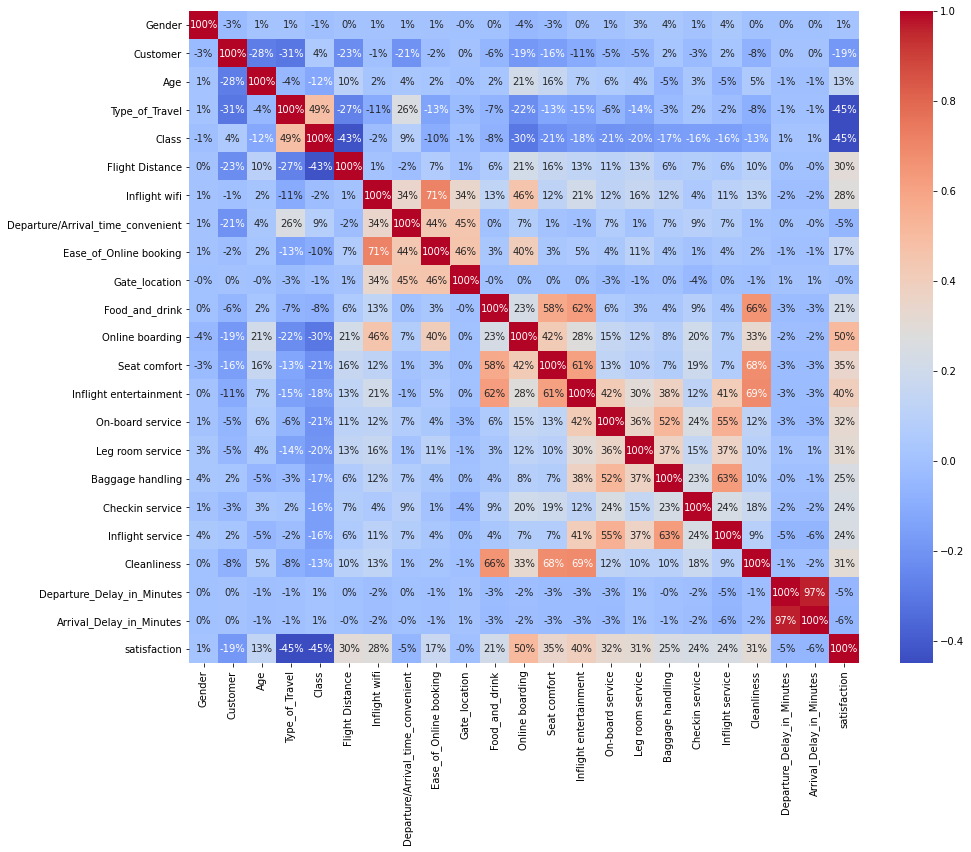

In [ ]:
# A glance at the correlations
ax = plt.figure(figsize=(15,12))
sns.heatmap(df2.corr(),annot=True,cmap="coolwarm",fmt='.0%')
plt.show()

In [ ]:
sns.pairplot(df2, hue="satisfaction")
plt.show()

In [ ]:
# cleanup—it drops the low-value of correlation columns, Gender, Gate_location, Arrival_Delay_in_Minutes
df = df.drop(["Gender", "Gate_location", "Arrival_Delay_in_Minutes"], axis=1)
df.head()

,Customer,Age,Type_of_Travel,Class,Flight Distance,Inflight wifi,Departure/Arrival_time_convenient,Ease_of_Online booking,Food_and_drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure_Delay_in_Minutes,satisfaction
0,Loyal Customer,60,Business travel,Business,912,2,2,2,4,3,2,2,2,2,2,3,2,2,39,neutral or dissatisfied
1,disloyal Customer,38,Business travel,Business,208,3,3,3,5,3,5,5,4,5,4,4,4,5,0,neutral or dissatisfied
2,Loyal Customer,31,Business travel,Business,3147,1,1,1,5,5,5,5,4,3,5,5,5,5,2,satisfied
3,Loyal Customer,53,Business travel,Business,2327,3,2,2,3,3,3,3,5,3,4,3,1,3,186,neutral or dissatisfied
4,Loyal Customer,30,Personal Travel,Eco,650,3,4,3,3,3,3,3,2,2,4,3,4,3,0,neutral or dissatisfied


In [ ]:
# Encode Labels With Scikitlearn
df3 = df.copy()
df3_encoded = pd.get_dummies(df3, columns=["Customer", "Type_of_Travel", "Class", "satisfaction" ])
df3_encoded

,Age,Flight Distance,Inflight wifi,Departure/Arrival_time_convenient,Ease_of_Online booking,Food_and_drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure_Delay_in_Minutes,Customer_Loyal Customer,Customer_disloyal Customer,Type_of_Travel_Business travel,Type_of_Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus,satisfaction_neutral or dissatisfied,satisfaction_satisfied
0,60,912,2,2,2,4,3,2,2,2,2,2,3,2,2,39,1,0,1,0,1,0,0,1,0
1,38,208,3,3,3,5,3,5,5,4,5,4,4,4,5,0,0,1,1,0,1,0,0,1,0
2,31,3147,1,1,1,5,5,5,5,4,3,5,5,5,5,2,1,0,1,0,1,0,0,0,1
3,53,2327,3,2,2,3,3,3,3,5,3,4,3,1,3,186,1,0,1,0,1,0,0,1,0
4,30,650,3,4,3,3,3,3,3,2,2,4,3,4,3,0,1,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388849,39,3483,1,1,1,3,5,4,5,5,5,5,4,5,3,0,1,0,1,0,1,0,0,0,1
388850,42,3636,0,5,0,2,5,4,1,1,1,1,3,1,3,0,1,0,1,0,1,0,0,0,1
388851,64,376,1,5,1,2,4,5,4,4,1,4,3,4,4,0,1,0,0,1,0,1,0,1,0
388852,57,192,5,5,5,2,4,5,4,4,5,4,5,4,5,0,1,0,0,1,0,1,0,0,1


In [ ]:
df3_encoded.columns

Index(['Age', 'Flight Distance', 'Inflight wifi',
       'Departure/Arrival_time_convenient', 'Ease_of_Online booking',
       'Food_and_drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure_Delay_in_Minutes', 'Customer_Loyal Customer',
       'Customer_disloyal Customer', 'Type_of_Travel_Business travel',
       'Type_of_Travel_Personal Travel', 'Class_Business', 'Class_Eco',
       'Class_Eco Plus', 'satisfaction_neutral or dissatisfied',
       'satisfaction_satisfied'],
      dtype='object')

In [ ]:
# Create features
X = df3_encoded.drop(columns=['satisfaction_neutral or dissatisfied', 'satisfaction_satisfied'], axis=1)

X.head()

,Age,Flight Distance,Inflight wifi,Departure/Arrival_time_convenient,Ease_of_Online booking,Food_and_drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure_Delay_in_Minutes,Customer_Loyal Customer,Customer_disloyal Customer,Type_of_Travel_Business travel,Type_of_Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus
0,60,912,2,2,2,4,3,2,2,2,2,2,3,2,2,39,1,0,1,0,1,0,0
1,38,208,3,3,3,5,3,5,5,4,5,4,4,4,5,0,0,1,1,0,1,0,0
2,31,3147,1,1,1,5,5,5,5,4,3,5,5,5,5,2,1,0,1,0,1,0,0
3,53,2327,3,2,2,3,3,3,3,5,3,4,3,1,3,186,1,0,1,0,1,0,0
4,30,650,3,4,3,3,3,3,3,2,2,4,3,4,3,0,1,0,0,1,0,1,0


In [ ]:
# Create target
y = df3_encoded["satisfaction_satisfied"].ravel()
y[:5]

array([0, 0, 1, 0, 0], dtype=uint8)

## Model
**Partition training data**

In [ ]:
from sklearn.model_selection import train_test_split


# Split training/test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1,stratify=y)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(291640, 23)
(97214, 23)
(291640,)
(97214,)


**sklearn modlues and regression models**

In [ ]:
# import sklearn modules
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.feature_selection import SelectFromModel

# Regression models 
names = ["LogisticReg","ExtraTrees","DecisionTree","RandomForest","AdaBoost", "GradientBoosting"]
clfs = [
LogisticRegression(solver='lbfgs',max_iter=10000, random_state=1),
ExtraTreesClassifier(n_estimators=300, max_depth=10, class_weight='balanced'),
DecisionTreeClassifier(max_depth=5),
RandomForestClassifier(n_estimators=128, random_state=78, class_weight='balanced'),
AdaBoostClassifier(n_estimators=200),
GradientBoostingClassifier(n_estimators=200,max_depth=5)
]


**Fit the model and Classification Report**

In [ ]:
# for loop for classification_reports
for name,clf in zip(names,clfs):
    clf.fit(X_train,y_train)
    predictions = clf.predict(X_test)
    acc_score = accuracy_score(y_test, predictions)
    print(name+"Classifier Report")
    print(f"Accuracy Score : {acc_score}")
    print(classification_report(y_test, predictions))

LogisticRegClassifier Report
Accuracy Score : 0.8752134466229144
              precision    recall  f1-score   support

           0       0.88      0.90      0.89     54976
           1       0.87      0.84      0.85     42238

    accuracy                           0.88     97214
   macro avg       0.87      0.87      0.87     97214
weighted avg       0.88      0.88      0.87     97214

ExtraTreesClassifier Report
Accuracy Score : 0.9405229699426009
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     54976
           1       0.93      0.93      0.93     42238

    accuracy                           0.94     97214
   macro avg       0.94      0.94      0.94     97214
weighted avg       0.94      0.94      0.94     97214

DecisionTreeClassifier Report
Accuracy Score : 0.9053119920999033
              precision    recall  f1-score   support

           0       0.91      0.92      0.92     54976
           1       0.90      0.88      0.8

## Visualization

LogisticReg Classifier Confusion_Matrix


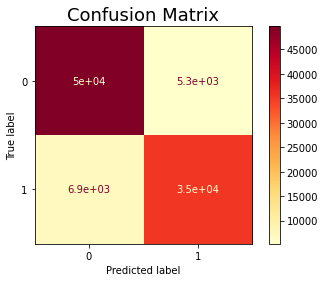

ExtraTrees Classifier Confusion_Matrix


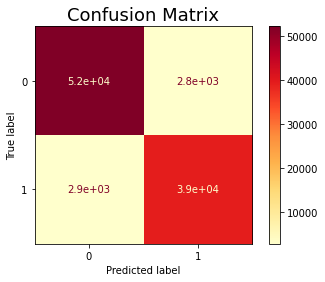

DecisionTree Classifier Confusion_Matrix


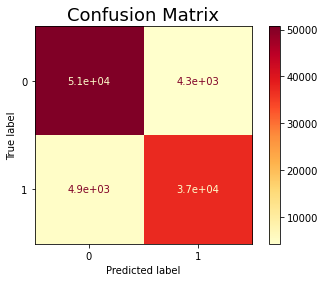

RandomForest Classifier Confusion_Matrix


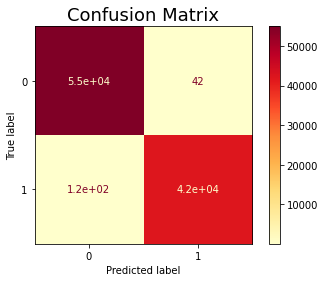

AdaBoost Classifier Confusion_Matrix


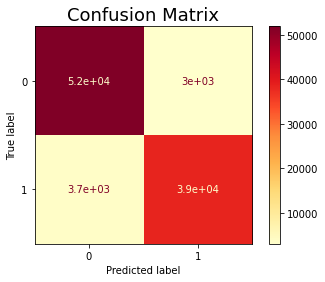

GradientBoosting Classifier Confusion_Matrix


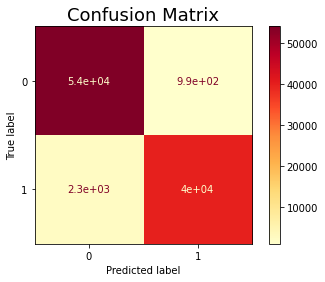

In [ ]:
# plot for confusion matrix
from sklearn.metrics import plot_confusion_matrix
for name,clf in zip(names,clfs):
    clf.fit(X_train,y_train)
    print(name+" Classifier Confusion_Matrix")
    plot_confusion_matrix(clf, X_test, y_test, cmap="YlOrRd")
    plt.title("Confusion Matrix", fontsize=18)
    plt.grid(b=False)
    plt.show()

Roc roc_auc_score:LogisticReg 0.9263158584047347
Roc roc_auc_score:ExtraTrees 0.9866097379484546
Roc roc_auc_score:DecisionTree 0.9682664532251577
Roc roc_auc_score:RandomForest 0.999966310969022
Roc roc_auc_score:AdaBoost 0.9798346071823804
Roc roc_auc_score:GradientBoosting 0.9955727083330004


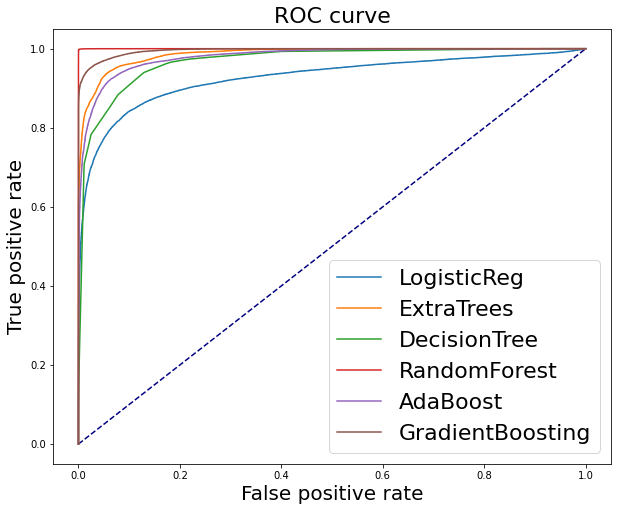

In [ ]:
# plot figure
plt.figure(figsize=(10,8))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

#loop for figure 
for name,clf in zip(names,clfs):
    # Fit the model
    clf.fit(X_train,y_train)
    y_proba = clf.predict_proba(X_test)[:,1]
    print("Roc roc_auc_score:"+name, roc_auc_score(y_test, y_proba, average='macro'))
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=name)


plt.xlabel('False positive rate', fontsize=20)
plt.ylabel('True positive rate', fontsize=20)
plt.title('ROC curve', fontsize=22)
plt.legend(loc='best', fontsize=22)
plt.savefig('1.png')
plt.show() 